## ConvLSTM Encoder and Decoder Architecture

In [12]:
import torch 
from training import ConvLSTM_GestureRecognitionModel
from colorVideoDataset import ColorVideoDataset
from datasetModule import GestureDataModule

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.metrics import confusion_matrix
from testDataset import VideoDataModule

In [13]:
MODEL_PATH = 'ConvLstm_final.pth'      
DATA_ROOT_DIR = './colors'            
BATCH_SIZE = 16
NUM_CLASSES = 8 
MODEL_CHECKPOINT = "checkpoints\convlstm-epoch=159-val_loss=0.35.ckpt"

<>:5: SyntaxWarning: invalid escape sequence '\c'
<>:5: SyntaxWarning: invalid escape sequence '\c'
C:\Users\Arnav Waghdhare\AppData\Local\Temp\ipykernel_12972\3299636933.py:5: SyntaxWarning: invalid escape sequence '\c'
  MODEL_CHECKPOINT = "checkpoints\convlstm-epoch=159-val_loss=0.35.ckpt"


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvLSTM_GestureRecognitionModel(num_classes=NUM_CLASSES).to(device)
model = ConvLSTM_GestureRecognitionModel.load_from_checkpoint(MODEL_CHECKPOINT)

model.eval() # Set the model to evaluation mode
print("Model loaded successfully and set to evaluation mode.")

Model loaded successfully and set to evaluation mode.


In [15]:
# data_module = VideoDataModule(
#     data_dir=DATA_ROOT_DIR,
#     batch_size=BATCH_SIZE
# )
dataset = GestureDataModule(data_dir=DATA_ROOT_DIR, batch_size=BATCH_SIZE)
class_names = ['black', 'blue', 'brown', 'green', 'orange', 'red', 'white', 'yellow']


In [16]:
# dataset = ColorVideoDataset(root_dir=DATA_ROOT_DIR, transform=None)
# 

In [17]:
import torch
import numpy as np
from training import ConvLSTM_GestureRecognitionModel

def infer(checkpoint_path, data_dir, data_module, batch_size=16, num_classes=8, gpus=1):
    # 2. Load the model from the checkpoint
    try:
        model = ConvLSTM_GestureRecognitionModel(num_classes=num_classes)
        state_dict = torch.load(checkpoint_path, map_location="cpu")
        model.load_state_dict(state_dict)

        print(f"✅ Model successfully loaded from '{checkpoint_path}'")
    except Exception as e:
        print(f"❌ Error loading model checkpoint: {e}")
        return None, None

    # 3. Put the model in evaluation mode and to device
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() and gpus > 0 else "cpu")
    model.to(device)
    
    data_module.setup()  
    loader = data_module.test_dataloader()

    all_preds, all_labels = [], []

    # 4. Run inference without gradient tracking
    with torch.no_grad():
        for batch_idx, batch in enumerate(loader ):
            if len(batch) == 3:
                x, y, _ = batch
            else:
                x, y = batch

            if x.ndim == 5:
                if x.shape[-1] == 3:
                    # (B,T,H,W,C) → (B,T,C,H,W)
                    x = x.permute(0, 1, 4, 2, 3)
                elif x.shape[1] == 3:
                    # Already correct shape: (B,C,T,H,W) → convert to (B,T,C,H,W)
                    x = x.permute(0, 2, 1, 3, 4)

            x = x.to(device)
            y = y.to(device)

            outputs = model(x)
            print(outputs)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

            if batch_idx % 10 == 0:
                print(f"Inference batch {batch_idx}/{len(loader)} complete")


    print("Inference completed.")
    return all_preds, all_labels


In [18]:
y_pred, y_true = infer(MODEL_PATH, DATA_ROOT_DIR, dataset)

✅ Model successfully loaded from 'ConvLstm_final.pth'
tensor([[ 1.0362, -0.4696, -2.3560, -4.6590, -2.4304,  6.3993, -0.8140, -1.8294],
        [-4.4085, -0.3988,  7.2028,  1.2356, -0.2212, -2.1189, -6.8310, -1.9271],
        [-0.0161, -2.4931, -3.7562, -3.4443, -1.7088,  1.6566,  4.7969, -1.3937],
        [-3.7613, -1.2471,  6.0388,  0.4216,  0.5803, -2.5269, -4.7014, -0.4696],
        [ 6.8208,  1.2434, -4.3902, -3.4134,  1.0098, -0.8535,  1.4409, -0.3499],
        [ 5.8626,  2.2411, -3.1448, -2.9194,  0.6495, -0.5027,  0.3641, -0.4659],
        [-2.4011, -0.2089,  4.0716,  2.1154,  0.7760, -2.7543, -3.7276, -2.1057],
        [-2.2021, -0.6313,  1.0353,  4.5591,  1.8346, -2.4535, -3.1659, -1.5245],
        [ 3.2209,  4.0064, -2.6777, -3.8783, -0.4830,  1.0652,  0.0750, -1.4586],
        [-2.4951,  0.7952, -1.4043, -0.7578,  2.0660, -2.4417, -0.0563,  2.6176],
        [ 1.7108, -0.2477, -2.9911, -5.1104, -2.2720,  7.2473, -0.2071, -2.5728],
        [ 2.3623,  5.0306,  0.3436, -1.4349,

In [19]:
y_pred

[np.int64(5),
 np.int64(2),
 np.int64(6),
 np.int64(2),
 np.int64(0),
 np.int64(0),
 np.int64(2),
 np.int64(3),
 np.int64(1),
 np.int64(7),
 np.int64(5),
 np.int64(1),
 np.int64(4),
 np.int64(6),
 np.int64(5),
 np.int64(3),
 np.int64(7),
 np.int64(3),
 np.int64(5),
 np.int64(2),
 np.int64(3),
 np.int64(7),
 np.int64(6),
 np.int64(0),
 np.int64(1),
 np.int64(4),
 np.int64(2),
 np.int64(4),
 np.int64(6),
 np.int64(7),
 np.int64(2),
 np.int64(3),
 np.int64(2),
 np.int64(4),
 np.int64(0),
 np.int64(6),
 np.int64(6),
 np.int64(0),
 np.int64(3),
 np.int64(3),
 np.int64(7),
 np.int64(6),
 np.int64(7),
 np.int64(7),
 np.int64(5),
 np.int64(3),
 np.int64(5),
 np.int64(6)]

### Confusion Matrix

In [20]:
def plot_confusion_matrix(y_true, y_pred, class_names=None, normalize=True, figsize=(8, 6), cmap="Blues"):
    cm = confusion_matrix(y_true, y_pred)
    
    # Normalize if requested
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
        cm = np.nan_to_num(cm)  # Handle any NaNs if a class has 0 samples

    # Prepare labels
    if class_names is None:
        num_classes = len(np.unique(y_true))
        class_names = [f"Class {i}" for i in range(num_classes)]

    # Plot
    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt=".2f" if normalize else "d", cmap=cmap,
                xticklabels=class_names, yticklabels=class_names)
    
    plt.title("Confusion Matrix" + (" (Normalized)" if normalize else ""))
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show()


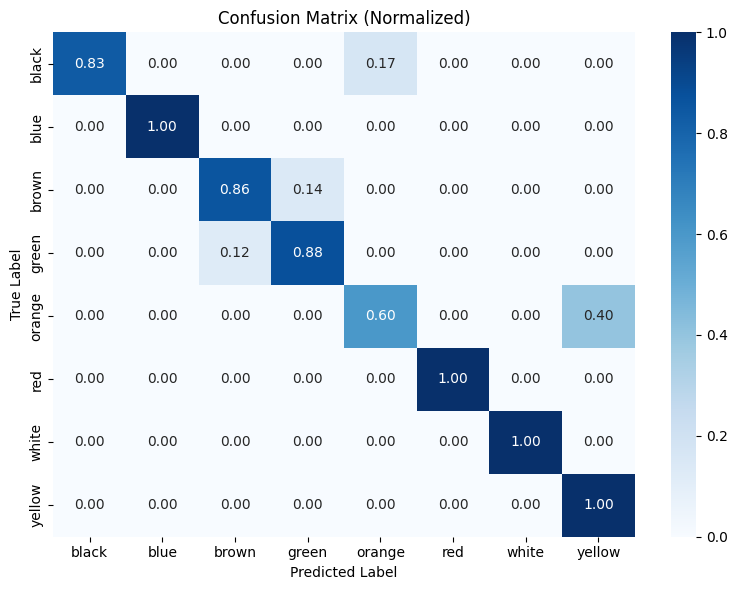

In [21]:
plot_confusion_matrix(y_true, y_pred, class_names=class_names, normalize=True)

### False Positives and False Negative's Matrix

In [22]:
cm = confusion_matrix(y_true, y_pred)

In [23]:
def calculate_ova_metrics(cm, class_names):
    metrics = {}
    # num_classes = len(class_names)
    
    for i, class_name in enumerate(class_names):
        TP = cm[i, i]
        
        FN = np.sum(cm[i, :]) - TP
        
        FP = np.sum(cm[:, i]) - TP
        
        TN = np.sum(cm) - (TP + FN + FP)
        
        metrics[class_name] = {'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN}
        
    df_metrics = pd.DataFrame.from_dict(metrics, orient='index')
    return df_metrics

In [24]:
df_ova_metrics = calculate_ova_metrics(cm, class_names)

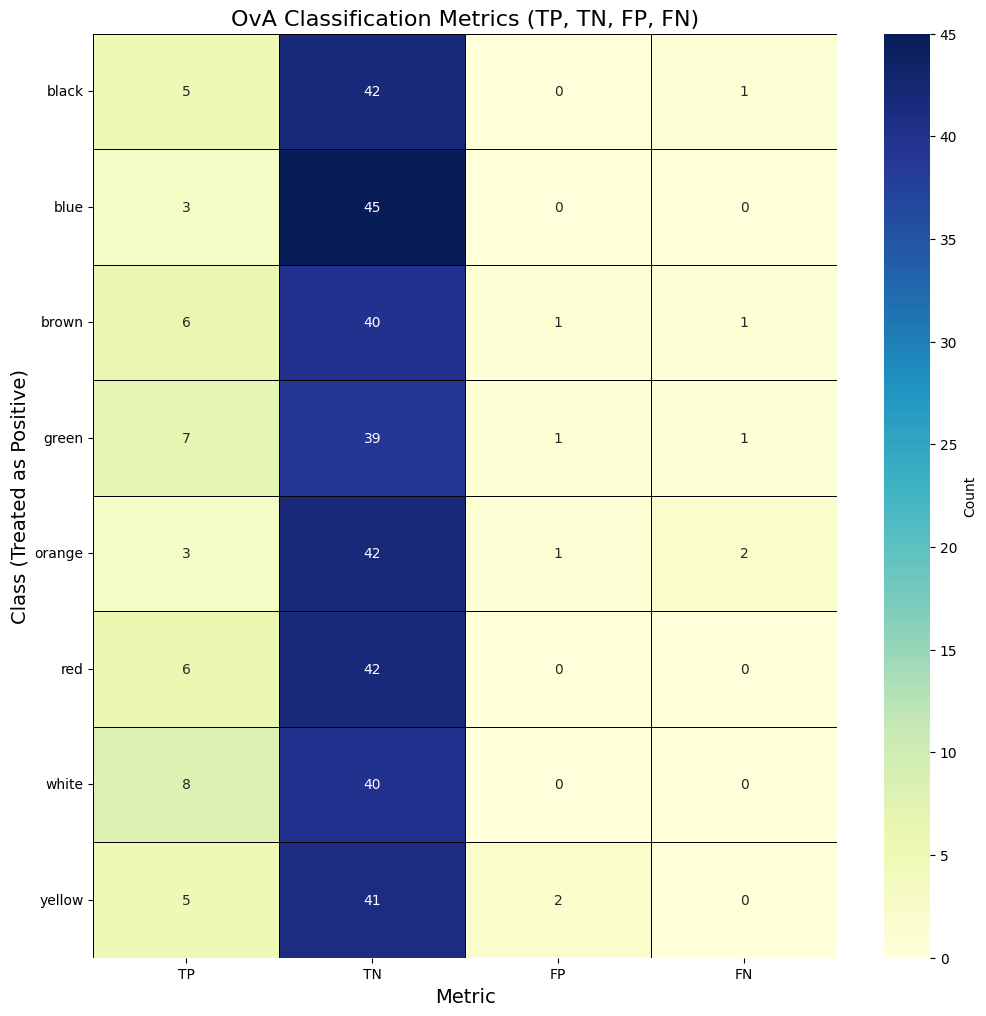

In [25]:
def plot_ova_metrics(df_metrics, title='One-vs-All Performance Matrix'):
    plt.figure(figsize=(12, df_metrics.shape[0] * 1.5))
    
    sns.heatmap(df_metrics, 
                annot=True, 
                fmt='d',         
                cmap='YlGnBu',    
                linewidths=.5,    
                linecolor='black',
                cbar_kws={'label': 'Count'})
    
    plt.title(title, fontsize=16)
    plt.ylabel('Class (Treated as Positive)', fontsize=14)
    plt.xlabel('Metric', fontsize=14)
    plt.yticks(rotation=0)
    plt.show()

plot_ova_metrics(df_ova_metrics, title='OvA Classification Metrics (TP, TN, FP, FN)')

### F1, Recall, Precision Per Class

In [26]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [27]:
def plot_metrics(y_true, y_pred, class_names):
    # Compute Precision, Recall, and F1-score per class
    precision = precision_score(y_true, y_pred, average=None)
    recall = recall_score(y_true, y_pred, average=None)
    f1 = f1_score(y_true, y_pred, average=None)
    
    # Create a DataFrame to hold the metrics
    metrics_df = pd.DataFrame({
        'Class': class_names,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })
    
    # Melt the dataframe for seaborn to plot
    metrics_df = metrics_df.melt(id_vars="Class", var_name="Metric", value_name="Score")
    
    # Set seaborn style
    sns.set(style="whitegrid")
    
    # Create the bar plot
    plt.figure(figsize=(10, 6))
    sns.barplot(data=metrics_df, x="Class", y="Score", hue="Metric", palette="Set2")
    
    # Customize plot
    plt.title('Precision, Recall, and F1 Score per Class', fontsize=16)
    plt.ylabel('Score', fontsize=12)
    plt.xlabel('Class', fontsize=12)
    plt.xticks(rotation=45)
    
    # Display the plot
    plt.tight_layout()
    plt.show()


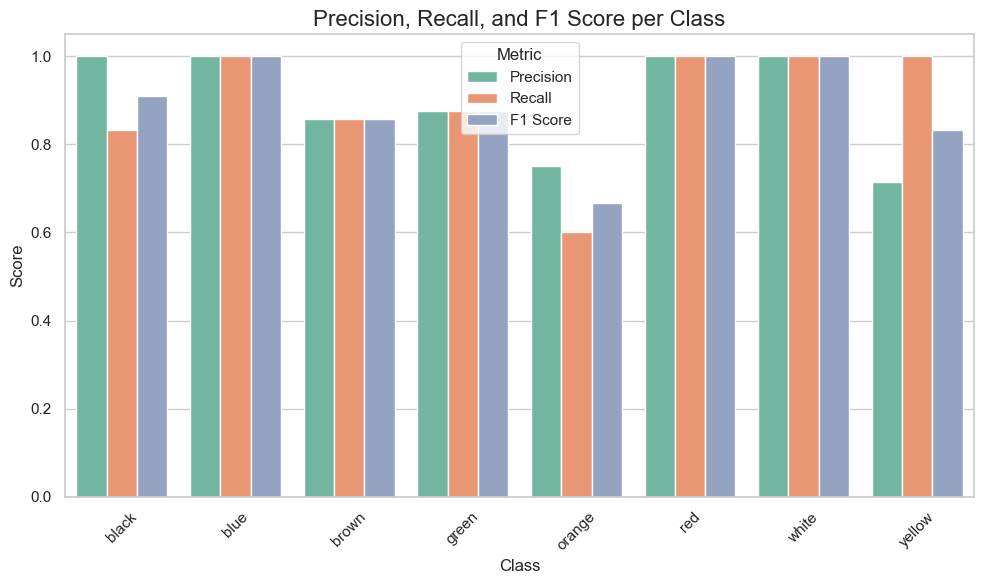

In [28]:
plot_metrics(y_true, y_pred, class_names)

## Using the Metrics CSV File

In [30]:
df = pd.read_csv("lightning_logs\\version_20\\metrics.csv")
sns.set_theme(style="whitegrid")

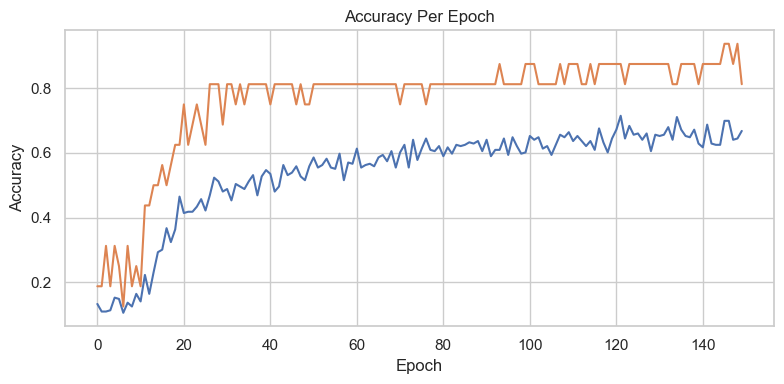

In [26]:
# ---- Accuracy Per Epoch ----
plt.figure(figsize=(8, 4))
sns.lineplot(data=df, x="epoch", y="train_acc", markers="o")
sns.lineplot(data=df, x="epoch", y="val_acc")
plt.title("Accuracy Per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.show()

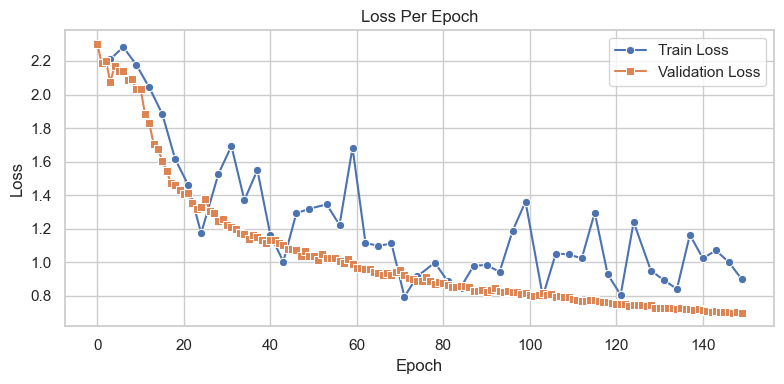

In [38]:
plt.figure(figsize=(8, 4))
sns.lineplot(data=df, x="epoch", y="train_loss", marker="o", label="Train Loss")
sns.lineplot(data=df, x="epoch", y="val_loss", marker="s", label="Validation Loss")
plt.legend(loc="best")
plt.title("Loss Per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.tight_layout()
plt.show()

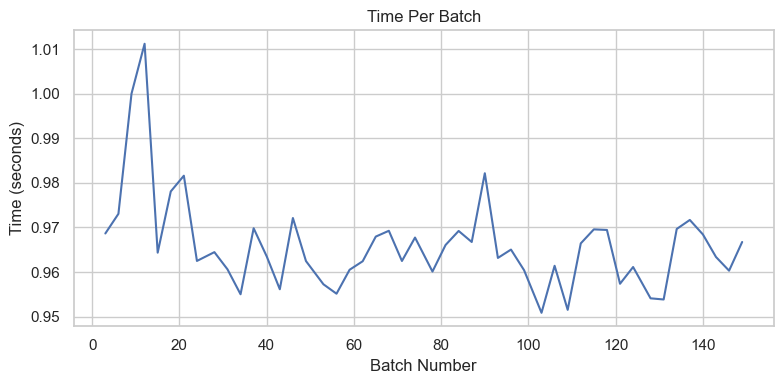

In [40]:
# ---- Time Per Batch ----
plt.figure(figsize=(8, 4))
sns.lineplot(data=df, x="epoch", y="train_batch_time_sec")
plt.title("Time Per Batch")
plt.xlabel("Batch Number")
plt.ylabel("Time (seconds)")
plt.tight_layout()
plt.show()

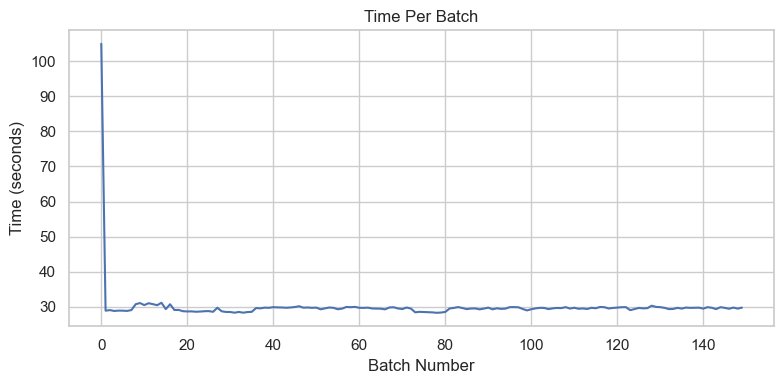

In [56]:
# ---- Time Per Epoch ----
plt.figure(figsize=(8, 4))
sns.lineplot(data=df, x="epoch", y="train_epoch_time_sec")
plt.title("Time Per Batch")
plt.xlabel("Batch Number")
plt.ylabel("Time (seconds)")
plt.tight_layout()
plt.show()